# Исследование данных игрового мобильного приложения

Вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.

**Задачи:**
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.  
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.  

**Предоставленные данные:**  
* `problem1-reg_data.csv` – данные о времени регистрации
* `problem1-auth_data.csv` – данные о времени захода пользователей в игру  
* `problem2.csv` – результаты A/B теста

## Этапы выполнения проекта

1. [Показатель Retention](#1.-Показатель-Retention)  
   - [1.1 Задача](#1.1-Задача)
   - [1.2 Загрузка данных](#1.2-Загрузка-данных)
   - [1.3 Предобработка данных](#1.3-Предобработка-данных)
   - [1.4 Расчет Retention](#1.4-Расчет-Retention)
   - [1.5 Результаты](#1.5-Результаты)
2. [A/B тестирование](#2.-A/B-тестирование)
   - [2.1 Задача](#2.1-Задача)
   - [2.2 Загрузка данных](#2.2-Загрузка-данных)
   - [2.3 Предобработка данных](#2.3-Предобработка-данных)
   - [2.4 Проверка гипотез](#2.4-Проверка-гипотез)
3. [Набор метрик для оценки результатов](#3.-Набор-метрик-для-оценки-результатов)

In [201]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

%matplotlib inline

## 1. Показатель Retention

### 1.1 Задача

**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

### 1.2 Загрузка данных

Изучим данные, предоставленные для проекта.

#### Данные о времени регистрации

Прочитаем файл `problem1-reg_data.csv` и сохраним его в переменной reg.

In [2]:
# чтение файла с данными с сохранением в reg
reg = pd.read_csv('problem1-reg_data.csv', sep=';')

Получение первых 10 строк таблицы.

In [3]:
# получение первых 10 строк таблицы.
reg.head(10)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
5,977206495,6
6,984222671,7
7,990407778,8
8,995943765,9
9,1000951674,10


Общая информация о данных таблицы reg.

In [4]:
# получение общей информации о данных в таблице reg
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца и 1000000 строк. Присутствует один тип данных: int64.

Подробно разберём, какие столбцы в reg содержат какую информацию:
* reg_ts — время регистриации в формате Unix timestamp
* uid — unique identifier (id пользователя)

Количество значений в столбцах одинаковое, пропущенные значения отсутствуют.

#### Данные о времени захода пользователей в игру

Прочитаем файл `problem1-auth_data.csv` и сохраним его в переменной reg.

In [5]:
# чтение файла с данными с сохранением в auth
auth = pd.read_csv('problem1-auth_data.csv', sep=';')

Получение первых 10 строк таблицы.

In [6]:
# получение первых 10 строк таблицы.
auth.head(10)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
5,934372615,2
6,934662633,2
7,935002586,2
8,935141232,2
9,935682752,2


Общая информация о данных таблицы reg.

In [7]:
# получение общей информации о данных в таблице auth
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
# проверка наличия пропущенных значений.
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
# получим количество строк в таблице
auth.shape[0]

9601013

Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца и 9601013 строк. Присутствует один тип данных: int64.

Подробно разберём, какие столбцы в auth содержат какую информацию:
* auth_ts — время захода пользователя в игру в формате Unix timestamp
* uid — unique identifier (id пользователя)

Количество значений в столбцах одинаковое, пропущенные значения отсутствуют.

#### Выводы

Каждая строка таблицы содержит id пользователя и временную отметку о его действии (регистрации или времени захода в игру). Пропуски в данных отсутствуют.

На следующем этапе необходимо будет:
* преобразовать временные отметки из формата Unix timestamp,
* сконвертировать uid в строковый формат (исключить возможные потери нулей и дальнейшие возможные проблемы, правда за счет некоторой незначительной для данного объема данных потери эффективности)  
* исследовать данные на наличие аномалий (например, регистрации с повторным присвоением уже использованного uid, аномальную частоту заходов пользователей в игру (отсечь ботов) и т.д.)

### 1.3 Предобработка данных

Сделаем преобразование временных отметок, сконвертируем uid в строковый формат и исследуем данные на наличие аномалий.

#### Данные о времени регистрации

**Сделаем преобразование столбца с временными отметками из Unix timestamp.**

In [10]:
# выполним преобразование
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s')

In [11]:
# посмотрим результаты преобразования
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


Ознакомимся с распределением диапазона дат.

In [12]:
# посмотрим описательную статистику
reg.reg_ts.describe(include='all', datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 12:12:34.523629056
min                1998-11-18 09:43:43
25%         2018-06-03 13:55:11.500000
50%                2019-07-30 02:35:25
75%      2020-04-01 16:28:40.499999744
max                2020-09-23 15:17:24
Name: reg_ts, dtype: object

Видим, что полный диапазон дат имеет значения от 1998-11-18 до 2020-09-23. Нижняя граница диапазона выглядит сомнительно, т.к. у мы разрабатываем мобильные игры.

Проверим процентое соотношение количества регистраций в тот или иной год.

In [13]:
# сгруппируем данные по года и посчитаем количество регистраций в процентах
reg_by_year = reg.reg_ts.dt.year.value_counts(normalize=True) \
                 .reset_index() \
                 .rename(columns={'index': 'year', 'reg_ts': 'regs_pct'}) 

In [14]:
# посмотрим на года с количеством регистраций больше одного процента
reg_by_year[reg_by_year['regs_pct'] >= 0.01]

,year,regs_pct
0,2020,0.354963
1,2019,0.291102
2,2018,0.159729
3,2017,0.087645
4,2016,0.048187
5,2015,0.026344
6,2014,0.014455


Дальше будем работать с данными начиная с 2014 года. Остальные данные будем считать выбросами и исключим из таблицы.

In [15]:
# сохраним данные в переменную reg_14
reg_14 = reg[reg.loc[:, 'reg_ts'] > '2014-01-01 00:00:00.000000000']

In [16]:
# сбросим индексы
reg_14.reset_index(inplace=True, drop=True)

In [17]:
# посмотрим описательную статистику
reg_14.reg_ts.describe(include='all', datetime_is_numeric=True)

count                           982425
mean     2019-03-09 11:11:10.245470208
min                2014-01-01 00:03:11
25%                2018-07-04 19:51:14
50%                2019-08-09 16:52:29
75%                2020-04-05 05:43:58
max                2020-09-23 15:17:24
Name: reg_ts, dtype: object

In [18]:
# посмотрим количество отсеченных строк
reg.shape[0] - reg_14.shape[0]

17575

In [19]:
# количество отсеченных строк в процентном соотношении
round((reg.shape[0] - reg_14.shape[0]) * 100 / reg.shape[0], 2)

1.76

Видим, что данные раньше 2014 года были отсечены (17575 строк или 1.76%).

**Преобразуем значения uid в строковый формат данных**

In [20]:
# преобразование типа данных столбца uid в строковые значения
reg_14.loc[:, ['uid']] = reg_14['uid'].astype('str')

/home/nktnlx/yes/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [21]:
# проверим верность выполнения
reg_14.dtypes

reg_ts    datetime64[ns]
uid               object
dtype: object

Преобразование uid в строковый формат было выполнено успешно.

**Проверим наличие регистраций пользователей с повторным присвоением уже использованного uid**

In [22]:
# отобразим количество встреченных дубликатов uid
reg_14.uid.duplicated().sum()

0

Повторного использования уже выданных uid не обнаружено.

#### Данные о времени захода пользователей в игру

**Сделаем преобразование столбца с временными отметками из Unix timestamp.**

In [23]:
# выполним преобразование
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s')

In [24]:
# посмотрим результаты преобразования
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


Ознакомимся с распределением диапазона дат.

In [25]:
# посмотрим описательную статистику
auth.auth_ts.describe(include='all', datetime_is_numeric=True)

count                          9601013
mean     2019-01-29 16:12:06.254660096
min                1998-11-18 09:43:43
25%                2018-06-07 12:40:47
50%                2019-07-31 12:43:16
75%                2020-04-02 10:25:21
max                2020-09-23 15:17:24
Name: auth_ts, dtype: object

Видим, что полный диапазон дат имеет значения от 1998-11-18 до 2020-09-23.

Как и для случая с регистрациями оставим только значения начиная с 2014 года. Остальные данные будем считать выбросами и исключим из таблицы.

In [26]:
# сохраним данные в переменную auth_14
auth_14 = auth[auth.loc[:, 'auth_ts'] > '2014-01-01 00:00:00.000000000']

In [27]:
# сбросим индексы
auth_14.reset_index(inplace=True, drop=True)

In [28]:
# посмотрим описательную статистику
auth_14.auth_ts.describe(include='all', datetime_is_numeric=True)

count                          9445996
mean     2019-03-10 11:48:49.205278464
min                2014-01-01 00:03:11
25%         2018-07-05 22:59:18.500000
50%                2019-08-10 05:59:40
75%      2020-04-05 16:38:24.249999872
max                2020-09-23 15:17:24
Name: auth_ts, dtype: object

In [29]:
# посмотрим количество отсеченных строк
auth.shape[0] - auth_14.shape[0]

155017

In [30]:
# количество отсеченных строк в процентном соотношении
round((auth.shape[0] - auth_14.shape[0]) * 100 / auth.shape[0], 2)

1.61

Видим, что данные раньше 2014 года были отсечены (155017 строк или 1.61%).

**Преобразуем значения uid в строковый формат данных**

In [31]:
# преобразование типа данных столбца uid в строковые значения
auth_14.loc[:, ['uid']] = auth_14['uid'].astype('str')

In [32]:
# проверим верность выполнения
auth_14.dtypes

auth_ts    datetime64[ns]
uid                object
dtype: object

Преобразование uid в строковый формат было выполнено успешно.

**Изучим статистику заходов пользователей в игру.**

In [33]:
# группировка по пользователям и подсчет количества заходов в игру
auth_freq = auth_14.groupby('uid', as_index=False) \
                   .agg({'auth_ts': 'count'}) \
                   .rename(columns={'auth_ts': 'visits'}) \
                   .sort_values('visits', ascending=False)

In [34]:
# описательная статистика распределения числа заходов пользователей в игру
auth_freq.visits.describe()

count    983392.000000
mean          9.605525
std          45.489029
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         647.000000
Name: visits, dtype: float64

Максимальное количество заходов в игру сильно отличается от среднего и медианного значения. Проверим время между заходами, чтобы исключить заходы ботов.

In [35]:
# группировка по пользователям и сортировка по времени захода
auth_14_delta = auth_14.reset_index() \
                       .groupby(['index', 'uid', 'auth_ts'], as_index=False) \
                       .agg({'index': 'count'}) \
                       .drop(columns='index') \
                       .sort_values(['uid', 'auth_ts'])

In [36]:
# подсчет разницы во времени между заходами
auth_14_delta['delta'] = auth_14_delta.auth_ts.diff(periods=1)

auth_14_delta

,uid,auth_ts,delta
690733,100000,2016-09-20 02:33:46,NaT
8485653,1000000,2020-07-21 19:58:14,1400 days 17:24:28
8485662,1000001,2020-07-21 19:59:12,0 days 00:00:58
8553022,1000001,2020-07-26 12:14:31,4 days 16:15:19
8593456,1000001,2020-07-29 07:45:01,2 days 19:30:30
...,...,...,...
9097164,999999,2020-09-01 04:42:45,3 days 12:16:06
9151803,999999,2020-09-04 18:14:23,3 days 13:31:38
9231540,999999,2020-09-09 22:14:16,5 days 03:59:53
9328627,999999,2020-09-16 03:59:54,6 days 05:45:38


In [37]:
# убираем всех у кого между сессиями меньше 5 минут 
# (возможные боты и пользователи не ставшие играть / случайные заходы в игру)
auth_14_delta = auth_14_delta[auth_14_delta['delta'] >= '0 days 00:05:00']

In [38]:
# сформируем перечень "нормальных" пользователей (не боты и не случайные заходы)
active_uids = auth_14_delta.uid.unique()

In [39]:
# уберем uid с аномальным числом заходов в игру из auth_14
auth_14_cleaned = auth_14.query('uid in @active_uids')

In [40]:
# посмотрим количество отсеченных строк
auth_14.shape[0] - auth_14_cleaned.shape[0]

645083

In [41]:
# количество отсеченных строк в процентном соотношении
round((auth_14.shape[0] - auth_14_cleaned.shape[0]) * 100 / auth_14.shape[0], 2)

6.83

Было отброшено 645083 аномальных строк (по частоте заходов в игру), что составляет 6.83%.

#### Выводы

Была произведена смена форматов данных (Unix timestamp --> date time; uid из целочисленых в строковые значения), проверка на дублирующие значения uid после регистрации (дубликатов выявлено не было), удаление не релевантных по дате данных (оставили данные начиная с 2014 года), а так же поиск и удаление аномальных значений по частоте захода в игру (удалено порядка 7% данных -- возможно боты или случайные заходы пользователей в игру, без самого процесса игры).

На следующем этапе необходимо будет посчитать retention пользователей.

### 1.4 Расчет Retention

#### Подготовка данных

Посчитаем retention (уровень удержания) игроков по дням от даты регистрации игрока. 

In [42]:
# объединим таблицы в один датафрейм по uid
data = auth_14_cleaned.merge(reg_14, how='left', on='uid')

data

,auth_ts,uid,reg_ts
0,2014-01-01 00:04:58,5460,NaT
1,2014-01-01 00:07:08,14320,NaT
2,2014-01-01 00:07:40,584,NaT
3,2014-01-01 00:11:19,17025,NaT
4,2014-01-01 00:12:46,5939,NaT
...,...,...,...
8800908,2020-09-23 14:36:14,1110570,2020-09-23 14:36:14
8800909,2020-09-23 14:43:15,1110580,2020-09-23 14:43:15
8800910,2020-09-23 14:50:15,1110591,2020-09-23 14:50:15
8800911,2020-09-23 14:58:08,1110600,2020-09-23 14:58:08


Были обнаружены пользователи со временем захода в приложение, но без времени регистрации. Посмотрим общее количество таких пользователей.

In [43]:
# Определяем количество строк без значений времени регистрации
data.reg_ts.isna().sum()

520363

Уберем таких пользователей из данных, т.к. по ним не возможно будет построить retention от даты регистрации.

In [44]:
# уберем пользователей без времени регистрации
data.dropna(subset=['reg_ts'], inplace=True)

In [45]:
# сбросим индекс
data.reset_index(drop=True, inplace=True)

In [46]:
# посмотрим количество отсеченных строк
auth_14_cleaned.shape[0] - data.shape[0]

520363

In [47]:
# количество отсеченных строк в процентном соотношении
round((auth_14_cleaned.shape[0] - data.shape[0]) * 100 / auth_14_cleaned.shape[0], 2)

5.91

Было отброшено 520363 строк без значений времени регистрации, что составляет 5.91%.

#### Функция расчета retention

Напишем функцию для расчета retention по дням.

In [48]:
# функция расчета retention по дням
def retention(data, reg_pos=2, auth_pos=0, uid_pos=1, min_date=None, max_date=None):
    '''Производит расчет retention по дням от даты регистрации пользователей.

    Parameters
    ----------
    data : dataframe
        Датафрейм с данными.
    reg_pos : int
        Номер колонки в датафрейме содержащий время регистрации
        (default is 2)
    auth_pos : int
        Номер колонки в датафрейме содержащий время входа
        (default is 0)
    uid_pos : int
        Номер колонки в датафрейме содержащий uid пользователя
        (default is 1)
    min_date : str
        Минимальная дата регистрации в формате 'yyyy-mm-dd' (включая)
        (default is None)
    max_date : str
        Максимальная дата регистрации в формате 'yyyy-mm-dd' (не включая)
        (default is None)    

    Returns
    -------
    dataframe
        Таблица retention
    '''

    # делаем выборку нужных колонок
    df = data.iloc[:, [uid_pos, reg_pos, auth_pos]].copy(deep=True)
    
    # проверка наличия и определение параметра min_date
    if min_date is None:
        min_date = df.reg_ts.min()
        
    # проверка наличия и определение параметра max_date
    if max_date is None:
        max_date = df.reg_ts.max()       

    # выносим даты регистрации и входа в приложение в отдельные колонки
    df['date_reg'] = df.reg_ts.dt.date
    df['date_auth'] = df.auth_ts.dt.date
    
    # делаем выборку по диапазону дат
    df = df[(df['reg_ts'] >= min_date) & (df['reg_ts'] <= max_date)]
    
    # посчитаем количество дней между датой регистрации и входом в приложение
    df['days'] = df['date_auth'] - df['date_reg']
    
    # сгруппируем по дням регистрации и количеству дней использования
    cohorts = df.groupby(['date_reg', 'days'], as_index=False) \
                  .agg({'uid': 'nunique'})  # агрегируем по уникальным пользователям
    
    # сформируем сводную таблицу
    cohorts_pivot = cohorts.pivot(index='date_reg', columns='days', values='uid')
    
    # посчитаем retention
    retention = pd.DataFrame()  # пустой датафрейм к которому будем прибавлять построково
    for i in range(cohorts_pivot.shape[0]):  #  итерируемся по строкам
        a = cohorts_pivot.iloc[i, 0]  # 100% число пользователей для этой даты
        temp = cohorts_pivot.iloc[i, :].divide(a, axis=0).round(4)  # получаем пересчет на проценты 
        retention = retention.append(temp)  # построково добавляем посчитанные значения в итоговую таблицу retention

    return retention

#### Функция отображения посчитанного retention

Напишем функцию для визуализации таблицы retention.

In [49]:
# функция построения таблицы retention
def plot_retention(data, product_lt=10, user_lt=10, savefig=False):
    '''Строит heatmap retention.

    Parameters
    ----------
    data : dataframe
        Датафрейм с посчитанными данными retention.
    product_lt : int
        Retention over product lifetime ("ось y").
        (default is 10)
    user_lt : int
        Retention over user lifetime ("ось х").
        (default is 0)
    savefig : bool
        Флаг сохранения полученной heatmap в jpeg.
        (default is False)

    Returns
    -------
    plotted retention heatmap
        Heatmap таблицы retention
    '''
    
    # выбираем нужный отрезок данных для вывода
    user_lt_lst = [_ for _ in range(user_lt)]
    plotting_slice = data.iloc[:product_lt, user_lt_lst]
    
    # отрисовка таблицы retention и ее оформление (заголовок, оси и т.д.)
    plt.figure(figsize=(16,9))
    ax = sns.heatmap(data=plotting_slice, fmt=' .2%', cmap='Blues', annot=True)
    ax.set_title('Retention Heatmap',fontsize= 18)
    xlabels = [f'Day {i}' for i in range(user_lt)]
    ax.set_xticklabels(xlabels, rotation=0)
    ax.xaxis.tick_top()
    
    # сохраняем heatmap в jpeg в рабочей директории
    if savefig == True:
        start = plotting_slice.index[0].strftime('%y%m%d')
        end = plotting_slice.index[plotting_slice.shape[0]-1].strftime('%y%m%d')
        plt.savefig(f'retention_{start}_{end}.jpg')

#### Проверка результатов работы функций

Проверим работу написанных функций и построим heatmap retention для периода с 01.09.2020 по 23.09.2020.

In [50]:
# посчитаем retention
retention_test = retention(data, min_date='2020-09-01', max_date='2020-09-24')

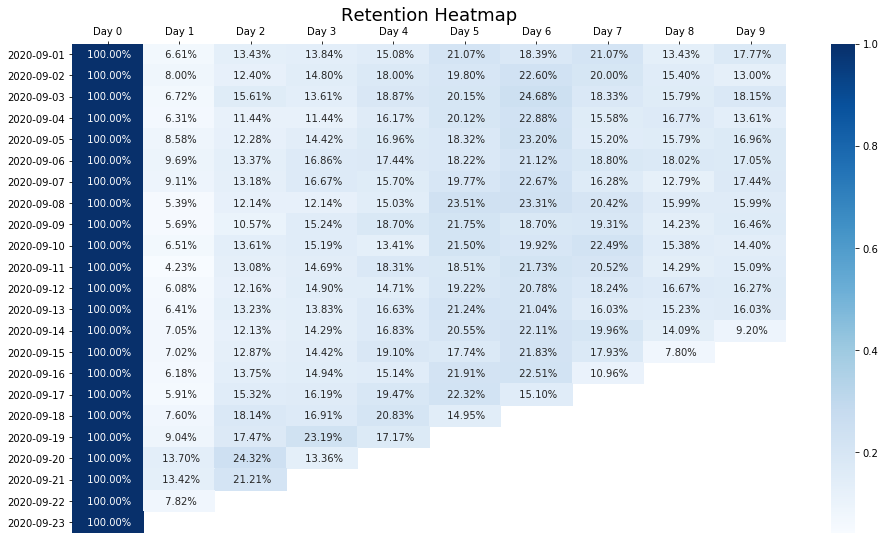

In [53]:
# построим heatmap с сохранением результата в jpg файл
plot_retention(retention_test, product_lt=23, user_lt=10, savefig=True)

#### Выводы

Функции расчета и отображения retention работают корректно.

### 1.5 Результаты

На данном этапе были написаны и задокументированы две функции: расчета и отображения таблицы retention. С помощью параметров функций возможно настраивать диапазон дат расчета и отображения retention, а также давать команду сохранять итоговую таблицу retention (heatmap) в jpg файл.  

Показатель retention очень важен. По нему можно судить о вовлеченности пользователя в продукт, а также отслеживать и предсказывать динамику его поведения. Например, на тестовых данных сентября 2020 года мы видим, что в основном пользователь начинает возвращаться в игру на второй день после регистрации (нулевой день). Максимальное удержание пользователей происходит на 4-7 дни использования продукта, после чего показатель retention начинает падать. В связи с этим стоит продумать об акциях и/или новых механиках игры, позволяющих увеличить удержание пользователей и после седьмого дня использования игры с момента регистрации пользователя.

## 2. A/B тестирование

### 2.1 Задача

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### 2.2 Загрузка данных

Изучим имеющиеся данные.

Прочитаем файл `problem2.csv` и сохраним его в переменной ab.

In [2]:
# чтение файла с данными с сохранением в ab
ab = pd.read_csv('problem2.csv', sep=';')

Получение первых 10 строк таблицы.

In [3]:
# получение первых 10 строк таблицы.
ab.head(10)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


Общая информация о данных таблицы ab.

In [4]:
# получение общей информации о данных в таблице ab
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 3 столбца и 404770 строк. Присутствует два типа данных: int64 (user_id, revenue) и object (testgroup).

Подробно разберём, какие столбцы в ab содержат какую информацию:
* user_id — user identifier (id пользователя)
* revenue — выручка с пользователя
* testgroup — принадлежность к контрольной или тестовой группе.

Количество значений в столбцах одинаковое, пропущенные значения отсутствуют.

#### Выводы

Каждая строка таблицы содержит id пользователя полученную с него выручку и флаг принадлежности к контрольной или тестовой группе. Пропуски в данных отсутствуют.

На следующем этапе необходимо будет:
* сконвертировать user_id в строковый формат (исключить возможные потери нулей и дальнейшие возможные проблемы, правда за счет некоторой незначительной для данного объема данных потери эффективности)  
* проверить наличие повторных значений user_id
* проверить работу сплит системы
* исследовать данные на наличие аномалий (например, отрицательные значения выручки, выбросы значений выручки и т.д.)
* провести тесты на нормальность распределения и гомогенность дисперсий
* определиться с выбором статистического критерия для проверки гипотез.

### 2.3 Предобработка данных

**Преобразуем значения user_id в строковый формат данных**

In [5]:
# преобразование типа данных столбца user_id в строковые значения
ab['user_id'] = ab['user_id'].astype('str')

In [6]:
# проверим верность выполнения
ab.dtypes

user_id      object
revenue       int64
testgroup    object
dtype: object

Преобразование user_id в строковый формат было выполнено успешно.

**Проверим наличие повторных значений user_id**

In [7]:
# отобразим количество встреченных дубликатов user_id
ab.user_id.duplicated().sum()

0

Повторного использования user_id не обнаружено.

**Проверим равномерность распределения пользователей на контрольную и тестовую группы**

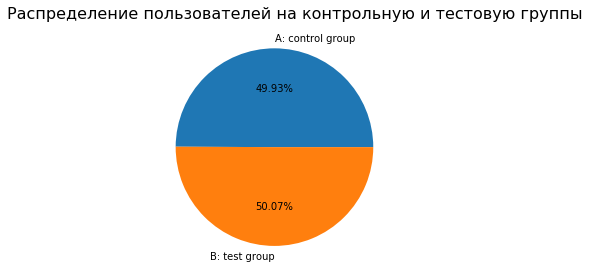

In [8]:
# группировка по группам
ab_counts = ab.groupby('testgroup').count().reset_index()

# отрисовка результатов распределения
plt.pie(ab_counts.revenue, labels=['A: control group', 'B: test group'], autopct='%0.2f%%')
plt.figtext(.56, .95,'Распределение пользователей на контрольную и тестовую группы', fontsize=16, ha='center')
plt.axis('equal');

Сплит система сработала корректно. Мы имеем практически равные по количеству группы пользователей.

**Ознакомимся с описательной статистикой выручки по группам**

In [9]:
# разбиение по группам и подсчет статистики
a = ab[ab['testgroup'] == 'a'].revenue.describe()
b = ab[ab['testgroup'] == 'b'].revenue.describe()

In [10]:
# сведение в одну таблицу
revenue_stats = pd.concat([a, b], axis=1, keys=['revenue A', 'revenue B'])

revenue_stats

,revenue A,revenue B
count,202103.000000,202667.000000
mean,25.413720,26.751287
std,920.768137,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,37433.000000,4000.000000


Отрицательных значений выручки не обнаружено. Максимальные значения и стандартные отклонения выборок сильно различаются.

In [11]:
# подсчет процентного соотношения средней выручки
rev_dif = ab[ab['testgroup'] == 'b'].revenue.mean() / ab[ab['testgroup'] == 'a'].revenue.mean()

# автоматизация знака разницы средней выручки при выводе на печать
if rev_dif - 1 > 0:
    sign = '+'
else:
    sign = ''

print(f'Средняя выручка в группе B отличается на {sign}{rev_dif - 1:.2%} от средней выручки в группе А.')

Средняя выручка в группе B отличается на +5.26% от средней выручки в группе А.


В дальнейшем проверим данное различие на стат значимость.

Подробнее рассмотрим распределение значений revenue внутри групп.

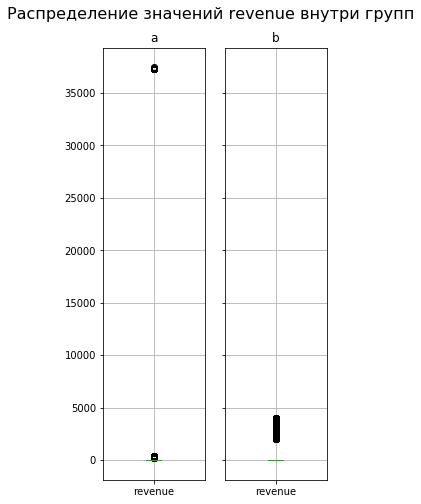

In [46]:
# построение графика типа боксплот (для revenue)
ab.groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .95,'Распределение значений revenue внутри групп', fontsize=16, ha='center');

В группе А в районе 37000 сконцентрирована группа аномальных значений.

Посмотрим на распределение значений (описательную статистику) для платящих пользователей.

In [50]:
# разбиение по группам и подсчет статистики
a_paid = ab[(ab['testgroup'] == 'a') & (ab['revenue'] > 0)].revenue.describe()
b_paid = ab[(ab['testgroup'] == 'b') & (ab['revenue'] > 0)].revenue.describe()

In [51]:
# сведение в одну таблицу
revenue_paid_stats = pd.concat([a_paid, b_paid], axis=1, keys=['revenue A', 'revenue B'])

revenue_paid_stats

,revenue A,revenue B
count,1928.000000,1805.000000
mean,2663.998444,3003.658172
std,9049.039763,572.619709
min,200.000000,2000.000000
25%,257.000000,2513.000000
50%,311.000000,3022.000000
75%,361.000000,3478.000000
max,37433.000000,4000.000000


Группы сильно отличаются между собой по большинству показателей. Стандартные отклонения отличаются почти в 16 раз. Медианные значения групп различаются примерно в 10 раз. 

Подробнее рассмотрим распределение значений revenue внутри групп для платящих пользователей.

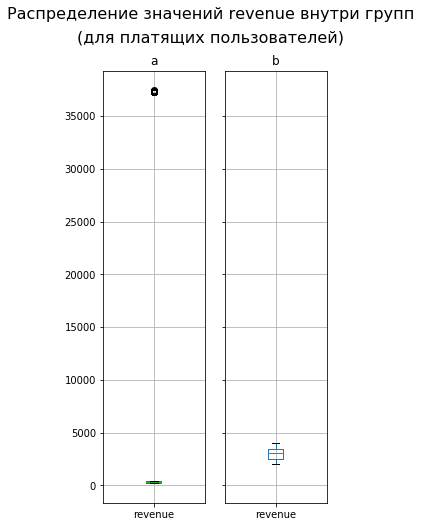

In [61]:
# построение графика типа боксплот (для revenue)
ab[ab['revenue'] > 0].groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .99,'Распределение значений revenue внутри групп', fontsize=16, ha='center');
plt.figtext(.35, .95,'(для платящих пользователей)', fontsize=16, ha='center');

В группе А в районе 37000 сконцентрирована группа аномальных значений. Похоже что это выбросы. Возможно связаны с ошибкой логирования (все эти аномальные значения примерно больше медианных значений группы А на 37000). Либо в группу А попали пользователи из "ультра-премиум" сегмента, а в группу B такие пользователи не попали, тогда это будет говорить о неверной работе системы сплитования.

Избавимся от этих выбросов.

In [64]:
# запишем значения без выбросов в новую переменную
ab_clean = ab.query('revenue < 5000')  # границу 5000 определили по предыдущему боксплоту

In [68]:
# сбросим индекс
ab_clean.reset_index(drop=True, inplace=True)

In [70]:
# посмотрим количество отсеченных строк
ab.shape[0] - ab_clean.shape[0]

123

In [72]:
# количество отсеченных строк в процентном соотношении
round((ab.shape[0] - ab_clean.shape[0]) * 100 / ab.shape[0], 2)

0.03

Было отброшено 123 строки с аномальными значениями выручки, что составляет 0.03% от общего числа строк.

**Ознакомимся с описательной статистикой выручки по группам (данные без выбросов)**

In [65]:
# разбиение по группам и подсчет статистики
a_clean = ab_clean[ab_clean['testgroup'] == 'a'].revenue.describe()
b_clean = ab_clean[ab_clean['testgroup'] == 'b'].revenue.describe()

In [66]:
# сведение в одну таблицу
revenue_stats_clean = pd.concat([a_clean, b_clean], axis=1, keys=['revenue A', 'revenue B'])

revenue_stats_clean

,revenue A,revenue B
count,201980.000000,202667.000000
mean,2.702926,26.751287
std,28.985815,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,400.000000,4000.000000


Отрицательных значений выручки не обнаружено. Максимальные значения и стандартные отклонения выборок различаются примерно в 10 раз.

In [67]:
# подсчет процентного соотношения средней выручки
rev_dif = ab_clean[ab_clean['testgroup'] == 'b'].revenue.mean() / ab_clean[ab_clean['testgroup'] == 'a'].revenue.mean()

# автоматизация знака разницы средней выручки при выводе на печать
if rev_dif - 1 > 0:
    sign = '+'
else:
    sign = ''

print(f'Средняя выручка в группе B отличается на {sign}{rev_dif - 1:.2%} от средней выручки в группе А.')

Средняя выручка в группе B отличается на +889.72% от средней выручки в группе А.


В дальнейшем проверим данное различие на стат значимость.

Подробнее рассмотрим распределение значений revenue внутри групп.

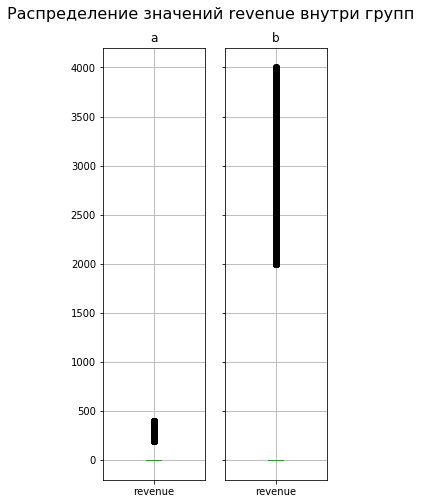

In [73]:
# построение графика типа боксплот (для revenue)
ab_clean.groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .95,'Распределение значений revenue внутри групп', fontsize=16, ha='center');

Выбросы присутствуют в обеих группах. Но пока рано делать выводы об их природе.

Посмотрим на распределение значений (описательную статистику) для платящих пользователей.

In [74]:
# разбиение по группам и подсчет статистики
a_paid_clean = ab_clean[(ab_clean['testgroup'] == 'a') & (ab_clean['revenue'] > 0)].revenue.describe()
b_paid_clean = ab_clean[(ab_clean['testgroup'] == 'b') & (ab_clean['revenue'] > 0)].revenue.describe()

In [75]:
# сведение в одну таблицу
revenue_paid_stats_clean = pd.concat([a_paid_clean, b_paid_clean], axis=1, keys=['revenue A', 'revenue B'])

revenue_paid_stats_clean

,revenue A,revenue B
count,1805.000000,1805.000000
mean,302.458172,3003.658172
std,57.914246,572.619709
min,200.000000,2000.000000
25%,254.000000,2513.000000
50%,305.000000,3022.000000
75%,352.000000,3478.000000
max,400.000000,4000.000000


Количество платящих пользователей в группах совпадает. Остальные **все(!)** показатели различаются в 10 раз. Есть подозрение в искусственной природе данных группы B путем умножения данных группы А на константу близкую к 10.

Подробнее рассмотрим распределение значений revenue внутри групп для платящих пользователей.

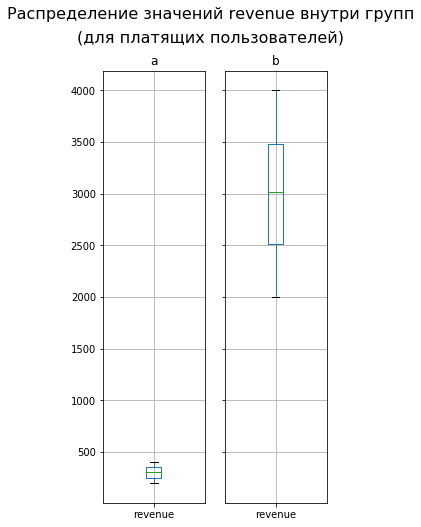

In [76]:
# построение графика типа боксплот (для revenue)
ab_clean[ab_clean['revenue'] > 0].groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .99,'Распределение значений revenue внутри групп', fontsize=16, ha='center');
plt.figtext(.35, .95,'(для платящих пользователей)', fontsize=16, ha='center');

Выбросы в группах А и B отсутствуют.

**Посмотрим на распределения значений выручки среди платящих пользователей.**

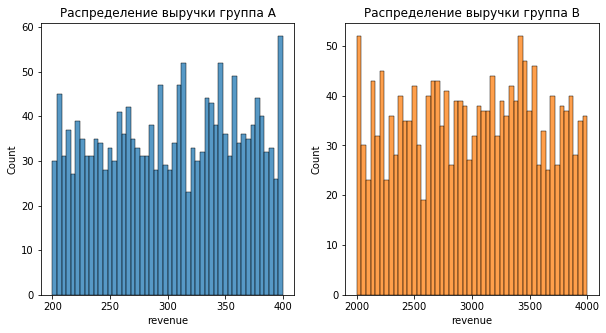

In [192]:
# размечаем пространство для вывода графиков
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 5)
)

# гистограмма распределения группа А
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'a')) & (ab_clean['revenue'] > 0)],
            x='revenue', bins=50, 
            ax=ax1)
ax1.set_title('Распределение выручки группа А')

# гистограмма распределения группа B
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'b')) & (ab_clean['revenue'] > 0)],
            x='revenue', bins=50, color='#FF7F0E',
            ax=ax2)
ax2.set_title('Распределение выручки группа B');

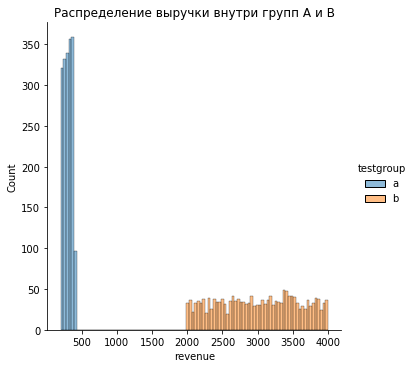

In [196]:
# отобразим на одном графике
sns.displot(data=ab_clean[ab_clean['revenue'] > 0], x='revenue', hue='testgroup', bins=100);
plt.title('Распределение выручки внутри групп A и B');

Дисперсия значений группы B значительно выше. 

**Проведем проверку на нормальность**

Контрольная группа А.

In [199]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'a'].revenue.sample(1000, random_state=17))  # sample 1000 для стабильности теста
alpha = 0.05  # уровень статистической значимости


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.0930, pvalue = 0.0000e+00
Распределение не является нормальным.


Тестовая группа B.

In [200]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'b'].revenue.sample(1000, random_state=17))  # sample 1000 для стабильности теста
alpha = 0.05  # уровень статистической значимости


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.0672, pvalue = 0.0000e+00
Распределение не является нормальным.


**Выполним тест Левена на гомогенность дисперсий**

In [232]:
# формируем выборки для проверки
sample_1 = ab_clean[ab_clean['testgroup'] == 'a'].revenue
sample_2 = ab_clean[ab_clean['testgroup'] == 'b'].revenue

alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# проверка равенства дисперсий
lv = st.levene(sample_1, sample_2)
if lv.pvalue > alpha:
    param = True
    print('Обе выборки имеют схожие дисперсии')
else:
    print('Дисперсии выборок различны.')
    param = False

Дисперсии выборок различны.


**Выполним преобразование (логарифимирование данных)**

Попробуем выполнить преобразовние данных с помощью логарифмирования, чтобы добиться нормальности распределения выборок.

In [224]:
# Прологарифмируем выборку
ab_clean['rev_log'] = ab_clean['revenue'].apply(lambda x: np.log(x + 0.0001))
ab_clean['rev_log'] = np.where(ab_clean['rev_log'] < 0, 0, ab_clean['rev_log'])

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Посмотрим на распределения значений выручки среди платящих пользователей после логарифмирования.

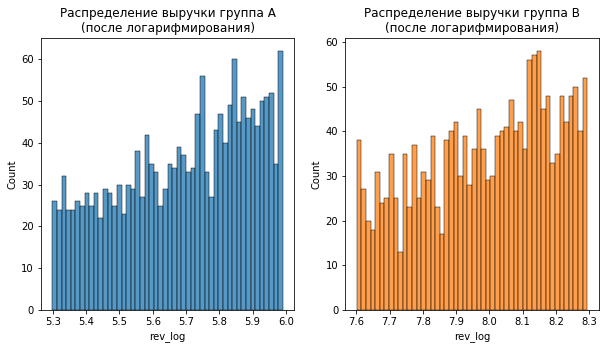

In [226]:
# размечаем пространство для вывода графиков
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 5)
)

# гистограмма распределения группа А
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'a')) & (ab_clean['revenue'] > 0)],
            x='rev_log', bins=50, 
            ax=ax1)
ax1.set_title('Распределение выручки группа А\n(после логарифмирования)')

# гистограмма распределения группа B
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'b')) & (ab_clean['revenue'] > 0)],
            x='rev_log', bins=50, color='#FF7F0E',
            ax=ax2)
ax2.set_title('Распределение выручки группа B\n(после логарифмирования)');

Нельзя сказать, что после логарифмирования распределения приняли нормальную форму. Чтобы в этом убедиться, проведем тест Шапиро-Уилка на нормальность.

**Проведем проверку на нормальность после логарифмирования**

Контрольная группа А.

In [227]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'a'].rev_log.sample(1000, random_state=17))  # sample 1000 для стабильности теста
alpha = 0.05  # уровень статистической значимости


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.0929, pvalue = 0.0000e+00
Распределение не является нормальным.


Тестовая группа B.

In [228]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'b'].rev_log.sample(1000, random_state=17))  # sample 1000 для стабильности теста
alpha = 0.05  # уровень статистической значимости


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.0666, pvalue = 0.0000e+00
Распределение не является нормальным.


**Выполним тест Левена на гомогенность дисперсий**

In [233]:
# формируем выборки для проверки
sample_1 = ab_clean[ab_clean['testgroup'] == 'a'].rev_log
sample_2 = ab_clean[ab_clean['testgroup'] == 'b'].rev_log

alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# проверка равенства дисперсий
lv = st.levene(sample_1, sample_2)
if lv.pvalue > alpha:
    param = True
    print('Обе выборки имеют схожие дисперсии')
else:
    print('Дисперсии выборок различны.')
    param = False

Дисперсии выборок различны.


#### Выводы

Столбец user_id был сконверирован в строковый формат, повторных значений user_id обнаружено не было, сплит система определила пользователей в контрольную и тестовую группу примерно поровну. В контрольной группе А было обнаружено 123 аномальных значения выручки (возможно связаны с ошибками логирования данных некоторых пользователей).  

Выборки не прошли тесты на нормальность и гомогенность дисперсий. Выполненные преобразования (логарифмирование) не помогло справиться с данной проблемой. Распределения значений выборок попрежнему не являются нормальными, а гомогенность дисперсий отсутствует.   

Будем использовать непараметрический тест Манна-Уитни для дальнейшей проверки гипотез.

На следующем этапе сформулируем нулевую и альтернативную гипотезу и выполним сравнение двух выборок с помощью непараметрического теста Манна-Уитни.

#### 2.4 Проверка гипотез

**Проведем эксперимент со значениями группы B** 

In [84]:
a = ab_clean[ab_clean['testgroup'] == 'a']

In [122]:
b = ab_clean[ab_clean['testgroup'] == 'b']

b[b['revenue']

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
550,552,2038,b
912,914,3902,b
...,...,...,...
403720,403844,3383,b
403871,403995,2793,b
404038,404162,2316,b
404070,404194,2998,b


In [159]:
r = 2
count = 0
c = 9.93
b['revenue_10'] = b['revenue'].apply(lambda x: x / c)

while round(a[a['revenue'] > 0].revenue.mean(), r) != round(b[b['revenue'] > 0].revenue_10.mean(), r):
    b = ab_clean[ab_clean['testgroup'] == 'b']
    b['revenue_10'] = b['revenue'].apply(lambda x: x / c)
    c += 0.0001
    count += 1
    print(count)
    a_mean = round(a[a['revenue'] > 0].revenue.mean(), r)
    b_mean = round(b[b['revenue'] > 0].revenue_10.mean(), r)
    print(f'Mean A: {a_mean}')
    print(f'Mean B: {b_mean}')
    print(f'Constant value: {c}')
    
    if b_mean < a_mean:
        print('!!!NOT FOUND!!!')
        break

print(f'The last constant value: {c}')
#print(f'Mean A: {round(a[a['revenue'] > 0].revenue.mean(), r)}')
#print(f'Mean B: {round(b[b['revenue'] > 0].revenue_10.mean(), r)}')

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

1
Mean A: 302.46
Mean B: 302.48
Constant value: 9.9301
2
Mean A: 302.46
Mean B: 302.48
Constant value: 9.9302
3
Mean A: 302.46
Mean B: 302.48
Constant value: 9.930299999999999


/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

4
Mean A: 302.46
Mean B: 302.47
Constant value: 9.930399999999999
5
Mean A: 302.46
Mean B: 302.47
Constant value: 9.930499999999999
6
Mean A: 302.46
Mean B: 302.47
Constant value: 9.930599999999998
7
Mean A: 302.46
Mean B: 302.46
Constant value: 9.930699999999998
The last constant value: 9.930699999999998


/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [163]:
#b['revenue'] = b['revenue'] / 10
b['revenue_10'] = b['revenue'].apply(lambda x: x / 10)
b.assign(revenue_10 = b.revenue / 10)

b[b['revenue'] > 0]

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,revenue,testgroup,revenue_10
160,161,3797,b,379.7
377,378,3768,b,376.8
386,387,3527,b,352.7
550,552,2038,b,203.8
912,914,3902,b,390.2
...,...,...,...,...
403720,403844,3383,b,338.3
403871,403995,2793,b,279.3
404038,404162,2316,b,231.6
404070,404194,2998,b,299.8


In [164]:
# разбиение по группам и подсчет статистики
a_paid = a[a['revenue'] > 0].revenue.describe()
b_paid = b[b['revenue'] > 0].revenue_10.describe()

In [165]:
# сведение в одну таблицу
rev_10 = pd.concat([a_paid, b_paid], axis=1, keys=['revenue A', 'revenue B'])

rev_10

,revenue A,revenue B
count,1805.000000,1805.000000
mean,302.458172,300.365817
std,57.914246,57.261971
min,200.000000,200.000000
25%,254.000000,251.300000
50%,305.000000,302.200000
75%,352.000000,347.800000
max,400.000000,400.000000


## 3. Набор метрик для оценки результатов